In [41]:
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from tensorflow.keras import regularizers
import os
import numpy as np
!pip install tqdm
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score

mkl-random 1.0.1 requires cython, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
#os.chdir("/Users/michelkauffmann/Downloads")
u = loadmat('u_F_xyz_T1.mat')["u_F"]
v = loadmat('v_F_xyz_T1.mat')["v_F"]
w = loadmat('w_F_xyz_T1.mat')["w_F"]
tau_11 = loadmat('tau11_xyz_T1.mat')["tau11"]

In [3]:
u.shape == v.shape == w.shape == tau_11.shape

True

In [4]:
tau_11.shape

(146, 96, 75)

In [5]:
x = np.array([u, v, w])
x = np.transpose(x, [1, 2, 3, 0])

In [6]:
x.shape

(146, 96, 75, 3)

In [7]:
x = np.pad(x, ((2,2), (2,2), (2,2), (0,0)), 'constant', constant_values = 0)

In [8]:
sample = []
size = 2
y = []
for i in tqdm_notebook(range(size, x.shape[0] - size)):
    for j in range(size, x.shape[1] - size):
        for k in range(size, x.shape[2] - size):
            sample.append(x[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
            y.append(tau_11[i-2][j-2][k-2])

In [9]:
x = np.stack(sample, axis = 0)
x.shape

(1051200, 5, 5, 5, 3)

In [10]:
y = np.array(y)
y.shape

(1051200,)

In [11]:
#mask =  np.random.rand(x.shape[0]) < 0.80
x_train, x_test = x[:800000, :, :, :, :], x[800000:, :, :, :, :]
y_train, y_test = y[:800000], y[800000:]

In [42]:
model = keras.Sequential([
    tf.keras.layers.Conv3D(32,
                     kernel_size = (2,2,2),
                     activation = "relu",
                     input_shape = (5,5,5,3),   
                     padding = "same",
                     kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling3D(pool_size = (2,2,2)),
    tf.keras.layers.Conv3D(64, 
                     kernel_size = (2,2,2), 
                     activation = "relu",
                     padding = "same",
                     kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling3D(pool_size = (2,2,2)),
    tf.keras.layers.Flatten(), #input_shape = (5,5,5,3)
    #tf.keras.layers.Dense(128, activation = tf.nn.relu),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(64, activation = tf.nn.relu),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation = tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)
])

In [43]:
model.compile(loss = 'mse',
                optimizer = tf.train.AdamOptimizer(),
                metrics = ['mse'])

In [44]:
#model = model
#model.summary()

In [45]:
"""
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               min_delta = 0.01,
                                               patience = 0,
                                               verbose = 1)
"""

"\nearly_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',\n                                               min_delta = 0.01,\n                                               patience = 0,\n                                               verbose = 1)\n"

In [ ]:
history = model.fit(x_train, y_train, 
                    epochs = 50,
                    validation_split = 0.2, 
                    batch_size = 5000)
                    #callbacks = [early_stopping])

Train on 640000 samples, validate on 160000 samples
Epoch 1/50
640000/640000 [==============================] - 9s 13us/step - loss: 0.4621 - mean_squared_error: 7.1588e-04 - val_loss: 0.0800 - val_mean_squared_error: 6.3784e-04
Epoch 2/50
640000/640000 [==============================] - 8s 13us/step - loss: 0.0256 - mean_squared_error: 6.1551e-04 - val_loss: 0.0038 - val_mean_squared_error: 7.0447e-04
Epoch 3/50
640000/640000 [==============================] - 8s 13us/step - loss: 0.0015 - mean_squared_error: 6.2928e-04 - val_loss: 7.7693e-04 - val_mean_squared_error: 7.0505e-04
Epoch 4/50
640000/640000 [==============================] - 8s 13us/step - loss: 6.4942e-04 - mean_squared_error: 6.2899e-04 - val_loss: 7.0795e-04 - val_mean_squared_error: 7.0484e-04
Epoch 5/50
640000/640000 [==============================] - 8s 13us/step - loss: 6.3023e-04 - mean_squared_error: 6.2909e-04 - val_loss: 7.0695e-04 - val_mean_squared_error: 7.0670e-04
Epoch 6/50
640000/640000 [=================

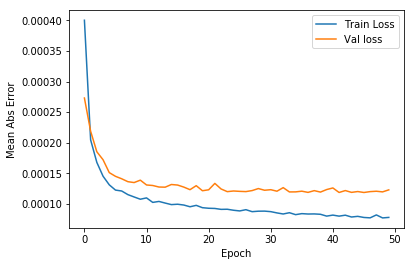

In [22]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.plot(history.epoch, np.array(history.history['mean_squared_error']), label = 'Train Loss')
plt.plot(history.epoch, np.array(history.history['val_mean_squared_error']), label = 'Val loss')
plt.legend()

In [30]:
y_pred = model.predict(x_test).flatten()
y_true = y_test

In [31]:
print("R^2: %.4f\n" % r2_score(y_true, y_pred))

R^2: 0.2385



In [36]:
np.corrcoef(y_pred, y_true)[0, 1]

0.7389941533442025